## Problem 7.1: Hacker stats and Darwin's finches

Attribution: Maddie and Zhiyang worked on this problem together. Maddie mostly worked on parts a,b,e, and Zhiyang worked on c,d,e. We discussed all the parts together.

In [1]:
import numpy as np
import pandas as pd
import scipy.special
import scipy.stats as st

import numba

import bebi103

import altair as alt
import altair_catplot as altcat

import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()

Loading BokehJS ...

**a)** We start with a little tidying of the data. Think about how you will deal with duplicate measurements of the same bird and make a decision on how those data are to be treated.

To start tidying up the data, we load in the data set and look at its structure.

In [2]:
# Read in the data
df = pd.read_csv('../data/finch_beaks.csv', comment='#')

# Take a look
df.head()

,band,species,beak length (mm),beak depth (mm),year
0,20123,fortis,9.25,8.05,1973
1,20126,fortis,11.35,10.45,1973
2,20128,fortis,10.15,9.55,1973
3,20129,fortis,9.95,8.75,1973
4,20133,fortis,11.55,10.15,1973


Let's look for duplicates based on band number and year.

In [3]:
pd.concat(g for _, g in df.groupby(['band', 'year']) if len(g) > 1)

,band,species,beak length (mm),beak depth (mm),year
102,316,fortis,10.9,9.70,1975
103,316,fortis,10.9,9.85,1975
304,818,fortis,10.2,9.00,1975
305,818,fortis,10.2,9.00,1975
363,944,fortis,10.3,8.30,1975
364,944,fortis,10.3,8.30,1975
365,945,fortis,11.6,10.80,1975
366,945,fortis,11.6,10.80,1975
2057,19028,fortis,12.5,8.90,2012
2178,19028,scandens,12.5,8.90,2012


It looks like for ID 19028, the species was identified as fortis and then as scandens, but the beak measurements are the same. For IDs 818, 944, and 945, the rows are exact duplicates. For band 316, the beak depth measurement is different.

Let's first drop complete duplicates.

In [4]:
df_deduped = df.drop_duplicates()

Now let's look at the remaining two duplicates. 

In [5]:
pd.concat(g for _, g in df_deduped.groupby(['band', 'year']) if len(g) > 1)

,band,species,beak length (mm),beak depth (mm),year
102,316,fortis,10.9,9.70,1975
103,316,fortis,10.9,9.85,1975
2057,19028,fortis,12.5,8.90,2012
2178,19028,scandens,12.5,8.90,2012


For band 19028, the bird has been identified as two different species. Let's see if there are any other measurements for this bird in other years to see if we can figure out what species it is.

In [6]:
df.loc[df['band'] == 19028]

,band,species,beak length (mm),beak depth (mm),year
2057,19028,fortis,12.5,8.9,2012
2178,19028,scandens,12.5,8.9,2012


It looks like this bird was only measured in 2012. 

Now let's look at the bird for band 316 and see if there are any other measurements that can tell us the true beak depth. 

In [7]:
df.loc[df['band'] == 316]

,band,species,beak length (mm),beak depth (mm),year
102,316,fortis,10.9,9.70,1975
103,316,fortis,10.9,9.85,1975


It seems like there aren't, so let's look at how many fortis measurements we have in 1975 to help us decide what we should do for these datapoints.

In [8]:
len(df.loc[(df['species'] == 'fortis') & (df['year'] == 1975)])

316

For ID 19208, it makes most sense to delete the rows since we have no idea what species the bird is. There are no other measurements in different years for this bird for us to check. For band 316, we could either take the mean of the beak depths or delete one of these rows or delete both rows as well. We decided to delete both rows for ID 316 as well because we don't know the true value of the beak depth, and there are 315 other fortis data points in 1975.

In [9]:
# Drop rows with duplicates
df_deduped = df_deduped.drop([2057,2178,102,103])

# Reset dataframe index
df_deduped = df_deduped.reset_index(drop=True)

We can also check for recordings of the same bird in different years.

In [10]:
pd.concat(g for _, g in df_deduped.groupby(['band', 'species']) if len(g) > 1)

,band,species,beak length (mm),beak depth (mm),year
418,364,scandens,14.00,8.40,1975
1285,364,scandens,14.00,8.40,1987
274,720,fortis,12.20,10.50,1975
1223,720,fortis,12.20,10.50,1987
732,2639,fortis,10.30,8.95,1987
1430,2639,fortis,10.30,8.95,1991
878,2666,fortis,12.81,9.30,1987
1431,2666,fortis,12.81,9.30,1991
1202,2753,fortis,10.89,10.35,1987
1432,2753,fortis,10.89,10.35,1991


For some birds, they measured the same bird over the different years. For example, taking bird with band 364, both measurements record the same beak length and beak depth. If this is the case for all of this kind of duplicate measurements, this could mean that the bird hasn't grown and that the inital measurement was accurate. If the values did change, maybe the bird grew from a juvenile to an adult. For now, we won't do anything with this information.

**b)** Plot ECDFs of the beak depths of Geospiza scandens in 1975 and in 2012. Then, estimate the mean beak depth in for each of these years with confidence intervals.

First let's slice out the beak depth values in numpy arrays.

In [11]:
inds_1975 = ((df_deduped['species'] == 'scandens') &
        (df_deduped['year'] == 1975))
    
inds_2012 = ((df_deduped['species'] == 'scandens') &
        (df_deduped['year'] == 2012))

depths_1975 = df_deduped.loc[inds_1975, 'beak depth (mm)'].values
depths_2012 = df_deduped.loc[inds_2012, 'beak depth (mm)'].values

Now we plot ECDFs of the beak depths of Geospiza scandens in 1975 and 2012.

In [12]:
p = bebi103.viz.ecdf(depths_1975,
                     x_axis_label='Scandens beak depth (mm)',
                     color='#4e79a7',
                     legend='1975')

p = bebi103.viz.ecdf(depths_2012,
                     x_axis_label='beak depth (mm)',
                     color='#f28e2b',
                     legend='2012',
                     p=p)

p.legend.location = 'bottom_right'

bokeh.io.show(p)

From the ECDF, we can see that the mean beak depth in 2012 has increased from what it was in 1975. Now let's estimate the mean beak depth in each of these years.

In [13]:
mean_1975 = np.mean(depths_1975)
mean_2012 = np.mean(depths_2012)

print("""
Mean beak depth in 1975 (mm): {0:.2f}
Mean beak depth in 2012 (mm): {1:.2f}
""".format(mean_1975, mean_2012))


Mean beak depth in 1975 (mm): 8.96
Mean beak depth in 2012 (mm): 9.19



The mean beak depth in 2012 is greater than the mean beak depth in 1975.

We will also estimate confidence intervals. First let's take some functions from Justin's tutorial for doing bootstrapping.

In [14]:
@numba.jit(nopython=True)
def draw_bs_sample(data):
    """
    Draw a bootstrap sample from a 1D data set.
    """
    return np.random.choice(data, size=len(data))


def draw_bs_reps(data, stat_fun, size=1):
    """
    Draw boostrap replicates computed with stat_fun from 1D data set.
    """
    return np.array([stat_fun(draw_bs_sample(data)) for _ in range(size)])


@numba.jit(nopython=True)
def draw_bs_reps_mean(data, size=1):
    """
    Draw boostrap replicates of the mean from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(data))
    return out

Now we use these functions to draw bootstrap replicates.

In [15]:
# Draw bootstrap samples
bs_reps_mean_1975 = draw_bs_reps_mean(depths_1975, size=10000)
bs_reps_mean_2012 = draw_bs_reps_mean(depths_2012, size=10000)

We can use these bootstrap replicates to calculate the confidence intervals.

In [16]:
# 95% confidence intervals
mean_1975_conf_int = np.percentile(bs_reps_mean_1975, [2.5, 97.5])
mean_2012_conf_int = np.percentile(bs_reps_mean_2012, [2.5, 97.5])

print("""
Mean beak depth 95% conf int in 1975 (mm): [{0:.2f}, {1:.2f}]
Mean beak depth 95% conf int in 2012 (mm): [{2:.2f}, {3:.2f}]
""".format(*(tuple(mean_1975_conf_int) + tuple(mean_2012_conf_int))))


Mean beak depth 95% conf int in 1975 (mm): [8.84, 9.08]
Mean beak depth 95% conf int in 2012 (mm): [9.07, 9.31]



There is slight overlap between these two confidence intervals. 

We can use the bootstrap replicates to plot the probability distribution of mean beak depths in 1975 and 2012.

In [17]:
p = bebi103.viz.ecdf(bs_reps_mean_1975,
                     x_axis_label='beak depth (mm)',
                     color='#4e79a7',
                     legend='1975')
p = bebi103.viz.ecdf(bs_reps_mean_2012, color='#f28e2b', legend='2012', p=p)

p.legend.location = 'bottom_right'

bokeh.io.show(p)

It looks like they are both Gaussian distributions with some overlap. The mean beak depth in 2012 for G. scandens in 2012 is higher than in 1975. 

**c)** Perform a hypothesis test comparing the G. scandens beak depths in 1975 and 2012. Carefully state your null hypothesis, your test statistic, and your definition of what it means to be at least as extreme as the observed test statistic. Comment on the results. It might be interesting to know that a severe drought in 1976 and 1977 resulted in the death of the plants that produce small seeds on the island.

We choose to start with a permutation test, where our null hypothesis is that the two distributions of G. scandens beak depths are exactly the same. As shown in the tutorial, we concentrate the two data sets into one, randomly scramble the order of the combined data set and designate the first $n$ entries in the scrambled array to be one of the test set and the rest to be the other. We use the function in Justin's notes to do so.

In [18]:
@numba.jit(nopython=True)
def draw_perm_sample(x, y):
    """Generate a permutation sample."""
    concat_data = np.concatenate((x, y))
    np.random.shuffle(concat_data)
    return concat_data[:len(x)], concat_data[len(x):]


Then we choose the difference of means as our test statisitic, where we basically take the means of two permutation data sets and calculate the differences. 

In [19]:
@numba.jit(nopython=True)
def draw_perm_reps_diff_mean(x, y, size=1):
    """
    Generate array of permuation replicates.
    """
    out = np.empty(size)
    for i in range(size):
        x_perm, y_perm = draw_perm_sample(x, y)
        out[i] = np.mean(x_perm) - np.mean(y_perm)
    return out

The extreme case of this test would be that the absolute value of the difference is larger than the absolute value of  difference of the means of two original data sets. Thus, to conduct this test, we draw many replicates and then calculate how many of them have more extreme differences of means than then original sets.

In [20]:
# Compute test statistic for original data set
diff_mean = np.abs(np.mean(depths_2012) - np.mean(depths_1975))

# Draw replicates
perm_reps = np.abs(draw_perm_reps_diff_mean(depths_2012, depths_1975, size=100000))

# Compute p-value
p_val = np.sum(perm_reps >= diff_mean) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.01006


Our p-value is small, around 0.01, which means that the probability of getting a difference of means as extreme as was observed under the null hypothesis that the control and test samples were drawn from identical distribution is small. 

We will next try to use the difference of the median as our test statistic. The way we do it is quite similar to what we do for the difference of the means. First we write a function to draw the replicates.

In [21]:
@numba.jit(nopython=True)
def draw_perm_reps_diff_median(x, y, size=1):
    """
    Generate array of permuation replicates.
    """
    out = np.empty(size)
    for i in range(size):
        x_perm, y_perm = draw_perm_sample(x, y)
        out[i] = np.median(x_perm) - np.median(y_perm)
    return out

Next we calculate the difference of medians and calculate the p-value.

In [22]:
# Compute test statistic for original data set
diff_median = np.abs(np.median(depths_2012) - np.median(depths_1975))

# Draw replicates
perm_reps = np.abs(draw_perm_reps_diff_median(depths_2012, depths_1975, size=100000))

# Compute p-value
p_val = np.sum(perm_reps >= diff_median) / len(perm_reps)

print('p-value =', p_val)

p-value = 0.06074


Our p-value is higher this time, and to make sure they are not just two distributions with the same median but different other properties, we use the bootstrap hypothesis to test. The null hypothesis becomes they have exactly the same median, and the test statisic is the difference of the medians. We modify the codes in the notes to shift two data sets so that they have the same median.

In [23]:
# Shift data sets
total_median = np.median(np.concatenate((depths_2012, depths_1975)))
depths_2012_shift = depths_2012 - np.median(depths_2012) + total_median
depths_1975_shift = depths_1975 - np.median(depths_1975) + total_median

#Plot the ECDFs
p = bebi103.viz.ecdf(depths_1975_shift,
                     x_axis_label='beak depth (mm)',
                     color='#4e79a7',
                     legend='1975')
p = bebi103.viz.ecdf(depths_2012_shift, color='#f28e2b', legend='2012', p=p)

p.legend.location = 'bottom_right'

bokeh.io.show(p)

Now, we can do the similar bootstrap test over the data sets with our modified code, where we can compute the difference of the medians from bootstrap replicates of those two data sets and compare those with the diffrence of the original data sets' medians.

In [24]:
@numba.jit(nopython=True)
def draw_bs_reps_diff_median(x, y, size=1):
    """
    Generate bootstrap replicates with difference of means
    as the test statistic.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.median(draw_bs_sample(x)) - np.median(draw_bs_sample(y))
    return out

# Generate samples
bs_reps = np.abs(draw_bs_reps_diff_median(depths_2012_shift, depths_1975_shift, 
                                 size=100000))

# Compute p-value
p_val = np.sum(bs_reps >= diff_median) / len(bs_reps)

print('p-value =', p_val)

p-value = 0.22689


The p-value is actually pretty high, which indicates that those two species could possibly have similar medians while they have quite different means. Just to make sure, we do the similar test with difference of means.

In [25]:
# Shift data sets
total_mean = np.mean(np.concatenate((depths_2012, depths_1975)))
depths_2012_shift = depths_2012 - np.mean(depths_2012) + total_mean
depths_1975_shift = depths_1975 - np.mean(depths_1975) + total_mean

@numba.jit(nopython=True)
def draw_bs_reps_diff_mean(x, y, size=1):
    """
    Generate bootstrap replicates with difference of means
    as the test statistic.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(x)) - np.mean(draw_bs_sample(y))
    return out

# Generate samples
bs_reps = np.abs(draw_bs_reps_diff_mean(depths_2012_shift, depths_1975_shift, 
                                 size=100000))

# Compute p-value
p_val = np.sum(bs_reps >= diff_mean) / len(bs_reps)

print('p-value =', p_val)

p-value = 0.00723


This p-value is pretty small. It is interesting that the mean of G. scandens beak depths changed significantly from 1975 to 2012, which could be because of the death of plants that produce small seeds.  As a result, they needed to change their beak depth to eat other food. The median did not change that much which might illustrate the process of evolution in a way that changes happened first to a certain population that gradually dominated the whole population rather than the whole population had this gradual change through a long time period.

**d)** Devise a measure for the shape of a beak. That is, invent some scalar measure that combines both the length and depth of the beak. Compare this measure between species and through time. (This is very open-ended. It is up to you to define the measure, make relevant plots, compute confidence intervals, and possibly do hypothesis tests to see how shape changes over time and between the two species.)

Our measure will be the ratio of beak length to beak depth, and we will look at how this measure changes through time.

In [26]:
# Calculate the ratio of beak length to beak depth
df_deduped['beak length to depth ratio'] = df_deduped['beak length (mm)'] / df_deduped['beak depth (mm)']

# Take a look
df_deduped.head()

,band,species,beak length (mm),beak depth (mm),year,beak length to depth ratio
0,20123,fortis,9.25,8.05,1973,1.149068
1,20126,fortis,11.35,10.45,1973,1.086124
2,20128,fortis,10.15,9.55,1973,1.062827
3,20129,fortis,9.95,8.75,1973,1.137143
4,20133,fortis,11.55,10.15,1973,1.137931


We slice out the beak length to depth ratios for each species for convenience.

In [27]:
alpha_s = df_deduped.loc[df_deduped['species'] == 'scandens', ['year', 'beak length to depth ratio']]
alpha_f = df_deduped.loc[df_deduped['species'] == 'fortis', ['year', 'beak length to depth ratio']]

Now we plot the ECDF of the beak length to depth ratio per species over time. 

In this plot, we have lines representing the beak length to depth ratio over time for each species. As the lines become darker, the year the data was measured is later in time.

In [28]:
years = df_deduped['year'].unique()
marker_year = np.linspace(0.2, 0.9, len(years))

p = bebi103.viz.ecdf(alpha_f.loc[alpha_f['year'] == years[0], 'beak length to depth ratio'], 
                     formal=True, 
                     line_width=2, 
                     color='#f28e2b', 
                     alpha=marker_year[0], 
                     legend='fortis')
p = bebi103.viz.ecdf(alpha_s.loc[alpha_s['year'] == years[0], 'beak length to depth ratio'], 
                     p=p, 
                     formal=True, 
                     line_width=2, 
                     color='#4e79a7', 
                     alpha=marker_year[0], 
                     legend='scandens')

for i in range(len(years) - 1):
    p = bebi103.viz.ecdf(alpha_f.loc[alpha_f['year'] == years[i+1], 'beak length to depth ratio'], 
                         p=p, 
                         formal=True, 
                         line_width=2, 
                         color='#f28e2b', 
                         alpha=marker_year[i+1], 
                         legend='fortis')
    p = bebi103.viz.ecdf(alpha_s.loc[alpha_s['year'] == years[i+1], 'beak length to depth ratio'], 
                         p=p, 
                         formal=True, 
                         line_width=2, 
                         color='#4e79a7', 
                         alpha=marker_year[i+1], 
                         legend='scandens')

p.legend.location = 'bottom_right'

bokeh.io.show(p)

For convenience, we have a function to compute the confidence intervals of the mean so that we can compare means of this ratio of different species in different years.

In [29]:
@numba.jit(nopython=True)
def mean_conf_int(data, size=1, alpha=5):
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(data))
    return np.percentile(out, [alpha/2, 100-alpha/2])

We can then calculate confidence intervals for their mean beak ratio in different years and make them into a data frame.

In [30]:
# Initialize the list 
alpha_s_mean_conf_int = []
alpha_f_mean_conf_int = []

# Compute the mean confidence interval
for year in years:
    temp = alpha_s.loc[alpha_s['year'] == year, 
                       'beak length to depth ratio'].values
    alpha_s_mean_conf_int.append(np.append(mean_conf_int(temp, size=10000),
                                           [np.mean(temp), 
                                           year]))
    temp = alpha_f.loc[alpha_f['year'] == year, 
                       'beak length to depth ratio'].values
    alpha_f_mean_conf_int.append(np.append(mean_conf_int(temp, size=10000),
                                           [np.mean(temp), 
                                           year]))

# Construct dataframes 
df_ratio_mean_conf_int_s = pd.DataFrame(alpha_s_mean_conf_int,columns=['low','high','mean','year'])
df_ratio_mean_conf_int_s['species'] = 'scandens'
df_ratio_mean_conf_int_f = pd.DataFrame(alpha_f_mean_conf_int,columns=['low','high','mean','year'])
df_ratio_mean_conf_int_f['species'] = 'fortis'

# Combine dataframes
df_ratio_mean_conf_int = pd.concat([df_ratio_mean_conf_int_s, 
                                    df_ratio_mean_conf_int_f]).reset_index(drop=True)

# Take a look
df_ratio_mean_conf_int

,low,high,mean,year,species
0,1.492799,1.608392,1.546423,1973.0,scandens
1,1.561879,1.595488,1.578882,1975.0,scandens
2,1.540503,1.569600,1.555354,1987.0,scandens
3,1.517395,1.555150,1.536562,1991.0,scandens
4,1.449531,1.483227,1.466321,2012.0,scandens
5,1.104875,1.127183,1.115817,1973.0,fortis
6,1.148956,1.160694,1.154860,1975.0,fortis
7,1.171418,1.181075,1.176285,1987.0,fortis
8,1.172919,1.183656,1.178273,1991.0,fortis
9,1.211212,1.236142,1.223569,2012.0,fortis


Now we can plot the mean confidence interval of two species over time.

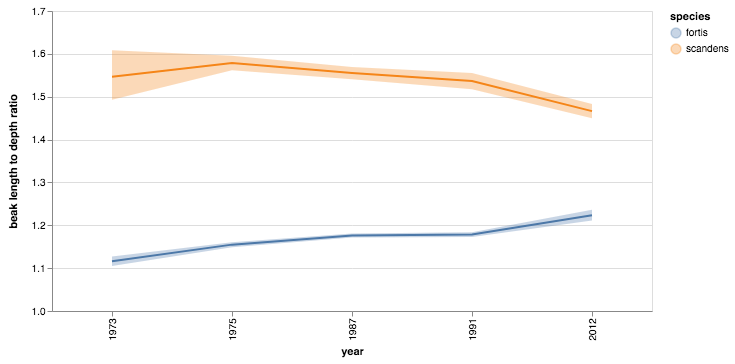

In [31]:
axis_scale = alt.Scale(domain=[1, 1.7])

mean = alt.Chart(df_ratio_mean_conf_int,
                width=600).mark_line().encode(
    x='year:O',
    y='mean:Q',
    color='species:N'
)

confidence_interval = alt.Chart(df_ratio_mean_conf_int,
                               width=600).mark_area(opacity=0.3).encode(
    x='year:O',
    y=alt.Y('low:Q', axis=alt.Axis(title='beak length to depth ratio'),scale=axis_scale),
    y2='high:Q',
    color='species:N'
)

confidence_interval + mean

It's not hard to tell that there is a difference in beak length to depth ratio between the two species and there may be differences among years. Thus, we conduct hypothesis tests on the difference of means of the ratio in each year and the year after that for each species respectively. The null hypothesis is then that they have the same mean in 1975 and 2012. For convenience, we have a function to do the bootstrap test of the mean differences.

In [32]:
@numba.jit(nopython=True)
def test_bs_diff_mean(x, y, size=1):
    """
    Bootstrap test for difference of means
    """
    total_mean = np.mean(np.concatenate((x, y)))
    x_shift = x - np.mean(x) + total_mean
    y_shift = y - np.mean(y) + total_mean
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(x_shift)) - np.mean(draw_bs_sample(y_shift))
    p_val = np.sum(np.abs(out) >= np.abs(np.mean(x) - np.mean(y))) / size
    return p_val

Then we can do the bootstrap test on the ratio in 1975 and in 2012 for G. fortis first:

In [33]:
# Initialize the list 
alpha_s_p_val = []
alpha_f_p_val = []

# Compute the p_value
for i in range(len(years) - 1):
    temp = alpha_s.loc[alpha_s['year'] == years[i], 
                       'beak length to depth ratio'].values
    temp1 = alpha_s.loc[alpha_s['year'] == years[i+1], 
                       'beak length to depth ratio'].values
    alpha_s_p_val.append(np.append(test_bs_diff_mean(temp, temp1, 100000),
                                   years[i]))
    
    temp = alpha_f.loc[alpha_f['year'] == years[i], 
                       'beak length to depth ratio'].values
    temp1 = alpha_f.loc[alpha_f['year'] == years[i+1], 
                       'beak length to depth ratio'].values
    alpha_f_p_val.append(np.append(test_bs_diff_mean(temp, temp1, 100000),
                                   years[i]))

# Construct and combine dataframes 
df_ratio_p_val_s = pd.DataFrame(alpha_s_p_val,columns=['p_val','year'])
df_ratio_p_val_s['species'] = 'scandens'
df_ratio_p_val_f = pd.DataFrame(alpha_f_p_val,columns=['p_val','year'])
df_ratio_p_val_f['species'] = 'fortis'

df_ratio_p_val = pd.concat([df_ratio_p_val_s, 
                                    df_ratio_p_val_f]).reset_index(drop=True)

# Take a look
df_ratio_p_val

,p_val,year,species
0,0.28557,1973.0,scandens
1,0.03755,1975.0,scandens
2,0.12020,1987.0,scandens
3,0.00000,1991.0,scandens
4,0.00000,1973.0,fortis
5,0.00000,1975.0,fortis
6,0.58878,1987.0,fortis
7,0.00000,1991.0,fortis


We can see directly from the data frame that for scandens, the ratio probably didn't change very significantly until 1991, while it might change to some extent in 1975. For fortis, it changed every year except 1987 when it probably didn't change much. 

**e)** Introgressive hybridization occurs when a G. scandens bird mates with a G. fortis bird, and then the offspring mates again with pure G. scandens. This brings traits from G. fortis into the G. scandens genome. As this may be a mode by which beak geometries of G. scandens change over time, it is useful to know how heritable a trait is. Heritability is defined as the ratio of the covariance between parents and offsprings to the variance of the parents alone. To be clear, the heritability is defined as follows.

Compute the average value of a trait in a pair of parents.
Compute the average value of that trait among the offspring of those parents.
Do this for each set of parents/offspring. Using this data set, compute the covariance among all average offspring and the variance among all average parents.
This is a more apt definition than, say, the Pearson correlation, because it is a direct comparison between parents and offspring.

Heritability data for beak depth for G. fortis and G. scandens can be found here and here, respectively. (Be sure to look at the files before reading them in; they do have different formats.) From these data, compute the heritability of beak depth in the two species, with confidence intervals. How do they differ, and what consequences might this have for introgressive hybridization?

First we read in the data for G. scandens.

In [34]:
df_hs = pd.read_csv('../data/scandens_beak_depth_heredity.csv', comment='#')
df_hs.head()

,mid_parent,mid_offspring
0,8.3318,8.4190
1,8.4035,9.2468
2,8.5317,8.1532
3,8.7202,8.0089
4,8.7089,8.2215


Now we read in the data for G. fortis.

In [35]:
df_hf = pd.read_csv('../data/fortis_beak_depth_heredity.csv', comment='#')
df_hf.head()

,Mid-offspr,Male BD,Female BD
0,10.70,10.90,9.3
1,9.78,10.70,8.4
2,9.48,10.70,8.1
3,9.60,10.70,9.8
4,10.27,9.85,10.4


We see that the two dataframes have different formats. We need to average the beak length trait from the male and female bird for the fortis dataset (from looking at the header of the scandens dataset, we know this is how they calculate mid_parent).

In [36]:
df_hf['mid_parent'] = (df_hf['Male BD'] + df_hf['Female BD']) / 2
df_hf['mid_offspring'] = df_hf['Mid-offspr']
df_hf = df_hf.drop(columns=['Male BD', 'Female BD', 'Mid-offspr'])
df_hf.head()

,mid_parent,mid_offspring
0,10.100,10.70
1,9.550,9.78
2,9.400,9.48
3,10.250,9.60
4,10.125,10.27


Now let's slice out the data as numpy arrays.

In [37]:
hs_par = df_hs['mid_parent'].values
hs_offsp = df_hs['mid_offspring'].values

hf_par = df_hf['mid_parent'].values
hf_offsp = df_hf['mid_offspring'].values

Now we define a function to draw bootstrap pairs and define a function to calculate the heritability, which is the ratio of the covariance between parents and offspring to the variance of the parents.

In [38]:
@numba.jit(nopython=True)
def draw_bs_pairs(x, y):
    """
    Draw a pairs bootstrap sample.
    """
    inds = np.arange(len(x))
    bs_inds = draw_bs_sample(inds)
    return x[bs_inds], y[bs_inds]

@numba.jit(nopython=True)
def heritability(par, offsp):
    '''Heritability is calculated as the ratio of 
    the covariance between parents and offspring 
    to the variance of the parents.
    r'''
    assert len(par) == len(offsp), 'Length of the arrays must be the same.'

    return np.sum((par - np.mean(par)) * (offsp - np.mean(offsp))) \
            / np.sum((par - np.mean(par)) * (par - np.mean(par)))

@numba.jit(nopython=True)
def draw_bs_pairs_reps_heritability(x, y, size=1):
    """
    Draw bootstrap pairs replicates.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = heritability(*draw_bs_pairs(x, y))
    return out

Now we draw our bootstrap pairs and calculate the heritability.

In [39]:
hf_reps = draw_bs_pairs_reps_heritability(hf_par, hf_offsp, size=10000)
hs_reps = draw_bs_pairs_reps_heritability(hs_par, hs_offsp, size=10000)

Here we plot the ECDFs of the beak depth heritability for each species.

In [40]:
p = bebi103.viz.ecdf(hs_reps, formal=True, line_width=2, color='#4e79a7', legend='scandens')
p = bebi103.viz.ecdf(hf_reps, p=p, formal=True, line_width=2, color='#f28e2b', legend='fortis')

p.legend.location = 'bottom_right'
bokeh.io.show(p)

We can also calculate the mean heritability for both species.

In [41]:
mean_hf = np.mean(hf_reps)
mean_hs = np.mean(hs_reps)

print("""
Mean G. fortis heritability for beak depth: {0:.2f}
Mean G. scandens heritablity for beak depth: {1:.2f}
""".format(mean_hf, mean_hs))


Mean G. fortis heritability for beak depth: 0.72
Mean G. scandens heritablity for beak depth: 0.55



As well as confidence intervals for the mean heritability.

In [42]:
conf_int_hf = np.percentile(hf_reps, [2.5, 97.5])
conf_int_hs = np.percentile(hs_reps, [2.5, 97.5])

print("""
G. fortis heritability 95% conf int (mm):   [{0:.2f}, {1:.2f}]
G. scandens heritability 95% conf int (mm): [{2:.2f}, {3:.2f}]
""".format(*(tuple(conf_int_hf) + tuple(conf_int_hs))))


G. fortis heritability 95% conf int (mm):   [0.65, 0.80]
G. scandens heritability 95% conf int (mm): [0.35, 0.75]



We can see that G. fortis has a higher heritability for beak depth than G. scandens, since from the ECDF and the mean most of the fortis birds show a sharp distribution of heritability around 0.72, while the scandens birds show a wider distribution of heritability around 0.55. The confidence interval for G. fortis is from 0.65 to 0.80, suggesting that a fortis parent is more likely to pass down its trait for beak depth than not. The confidence intervals for both species are overlapping, but G. scandens has a wider confidence interval and a wider distribution on the ECDF. As a result, it looks like G. scandens overall is less likely to pass down its trait for beak length than G. fortis is. If there is interogressive hybridization between G. scandens and G. fortis, the beak depth of the fortis parent may be more likely to be passed down to the offspring. This could be one method by which the beak geometry changes over time, in addition to environmental and other factors. 

In [43]:
%load_ext watermark

In [44]:
%watermark -v -p numpy,pandas,altair,jupyterlab

CPython 3.7.0
IPython 7.0.1

numpy 1.15.2
pandas 0.23.4
altair 2.2.2
jupyterlab 0.35.0
